In [1]:
# Task 2: Image Restoration using Autoencoder Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
import cv2
import math

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# Resize/reshape to (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


In [10]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

# Apply degradation
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)


In [11]:
from tensorflow.keras import layers, models

def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))
    
    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = models.Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')


In [12]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1246 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1116 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.1121 - val_loss: 0.1140


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average PSNR: 10.231112407007311


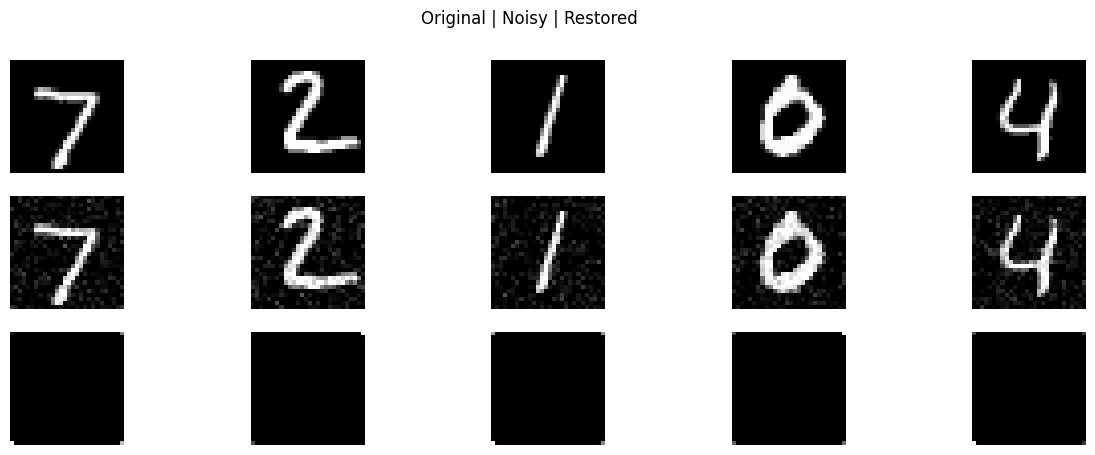

In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Predict restored images
x_decoded = autoencoder.predict(x_test_noisy)

# Evaluate PSNR
avg_psnr = np.mean([psnr(x_test[i], x_decoded[i]) for i in range(100)])
print("Average PSNR:", avg_psnr)

# Show original, noisy, and restored images
n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # Original
    plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Noisy
    plt.subplot(3, n, i+1+n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Denoised
    plt.subplot(3, n, i+1+2*n)
    plt.imshow(x_decoded[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Original | Noisy | Restored")
plt.show()
